In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imsave
import tensorflow as tf
import keras.backend as K
!pip install array2gif
from array2gif import write_gif
import datetime

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 
 
lstm_model = tf.keras.models.load_model('lstm_model5', custom_objects={'f1_m':f1_m})

In [3]:
PATH = '/Users/zhaoyu/PycharmProjects/CalFireMonitoring/data/evaluate/N31179/reference_dataset/N31179 dataset_ref_trial5300*250.npy'
# predict_dataset = np.load('/Users/zhaoyu/PycharmProjects/SampleDemo/notebooks/bond_fire dataset_ref_trial5256*240.npy')
predict_dataset = np.load(PATH)
# predict_dataset = np.load('/Users/zhaoyu/PycharmProjects/SampleDemo/notebooks/Doctor_creek_fire dataset_ref_trial5304*208.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/blue_ridge_fire dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/silverado_fire dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/August_complex dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/CZU_lighting_complex dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/LNU_lighting_complex dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/My Drive/evaluate/SCU_lighting_complex dataset_ref_trial5.npy')
# predict_dataset = np.load('/content/drive/MyDrive/evaluate/chuckegg_creek_fire dataset_ref_trial5300*250.npy')
# predict_dataset = np.load('/content/drive/MyDrive/evaluate/babine_complex dataset_ref_trial5300*250.npy')
# predict_dataset = np.load('/content/drive/MyDrive/evaluate/fraser_complex dataset_ref_trial5300*250.npy')
# predict_dataset = np.load('/content/drive/MyDrive/evaluate/stikine_complex dataset_ref_trial5300*250.npy')

predict_dataset = predict_dataset.transpose((1,0,2))

In [4]:
import cv2
predict_dataset = predict_dataset[:,:,:121]

new_predict_dataset = np.zeros((predict_dataset.shape[0],predict_dataset.shape[1],predict_dataset.shape[2]))
for i in range(predict_dataset.shape[1]):
  # print(predict_dataset_image[:,i,:].mean())
  ret,predict_dataset[:,i,:] = cv2.threshold(predict_dataset[:,i,:],4,100,cv2.THRESH_TOZERO)

predict_dataset_mean = predict_dataset.mean()
predict_dataset_std = predict_dataset.std()
# predict_dataset_label = predict_dataset[:, 20:40, 25:]
# predict_dataset_label_mean = predict_dataset_label.mean()
# predict_dataset_label_std = predict_dataset_label.std()

new_predict_dataset = (predict_dataset - predict_dataset_mean) / predict_dataset_std

# predict_dataset_label_norm = (predict_dataset_label - predict_dataset_label_mean) / predict_dataset_label_std
oupput_lstm = lstm_model.predict(new_predict_dataset)


00:00to00:59
01:00to01:59
02:00to02:59
03:00to03:59
04:00to04:59
05:00to05:59
06:00to06:59
07:00to07:59
08:00to08:59
09:00to09:59
10:00to10:59
11:00to11:59
12:00to12:59
13:00to13:59
14:00to14:59
15:00to15:59
16:00to16:59
17:00to17:59
18:00to18:59
19:00to19:59
20:00to20:59


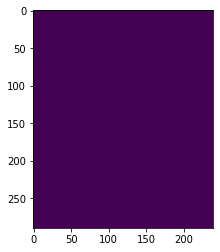

/Users/zhaoyu/PycharmProjects/CalFireMonitoring/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/zhaoyu/PycharmProjects/CalFireMonitoring/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/zhaoyu/PycharmProjects/CalFireMonitoring/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/zhaoyu/PycharmProjects/CalFireMonitoring/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

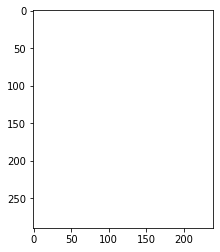

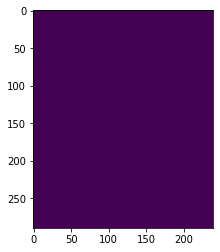

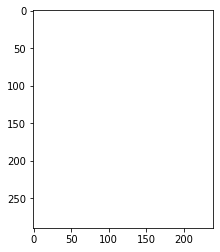

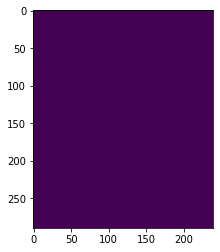

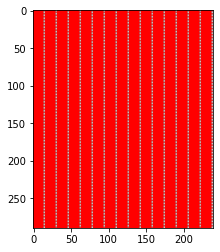

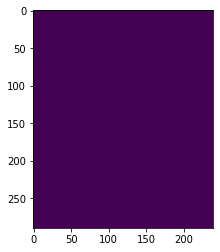

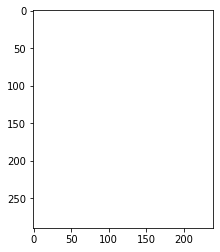

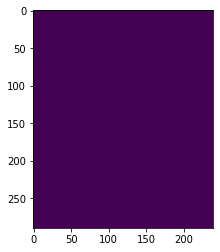

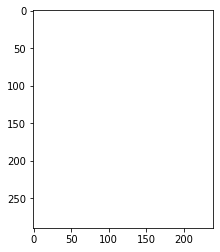

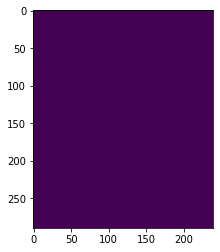

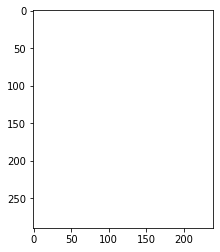

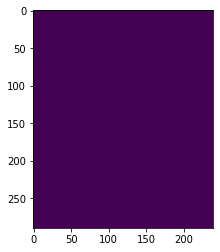

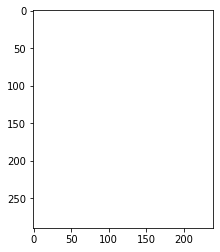

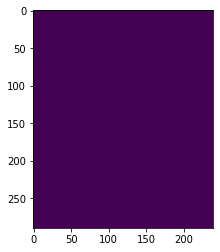

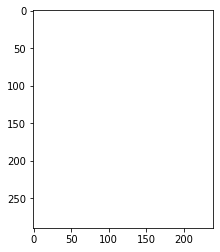

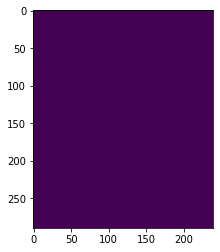

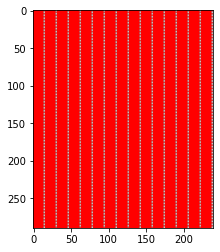

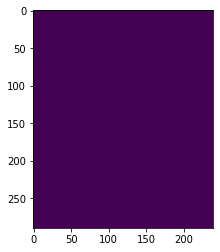

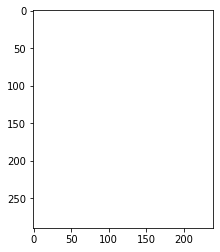

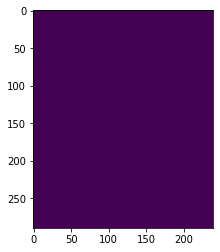

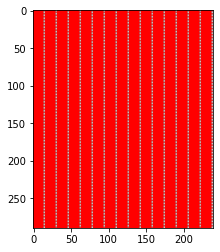

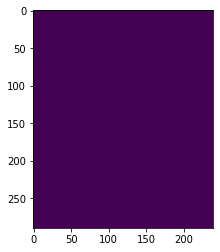

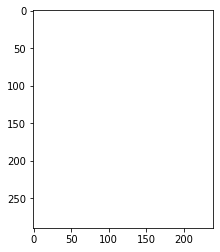

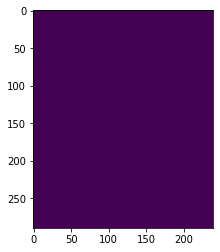

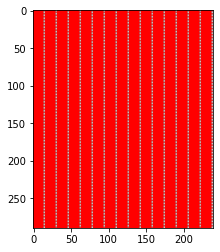

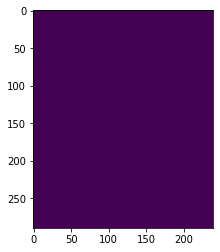

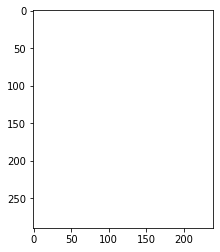

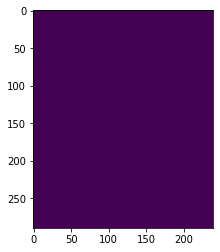

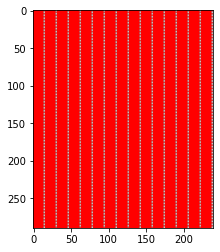

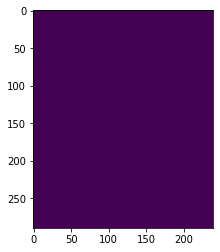

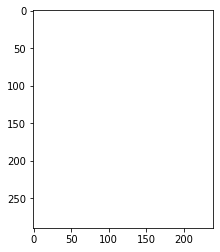

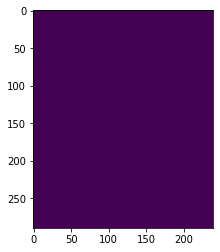

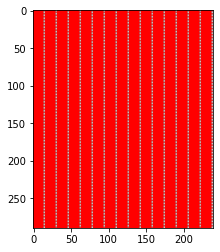

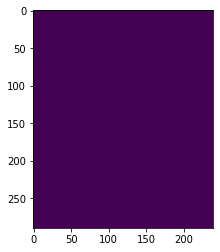

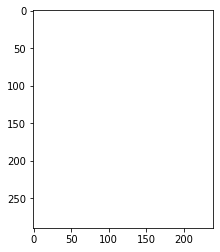

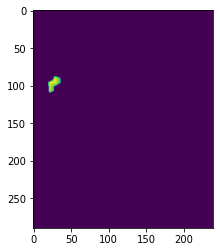

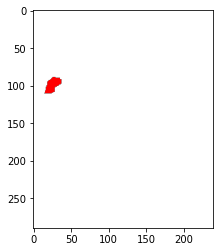

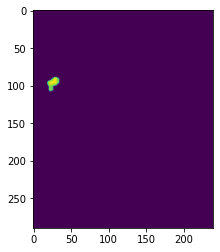

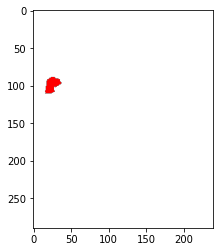

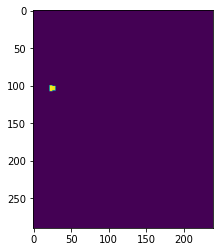

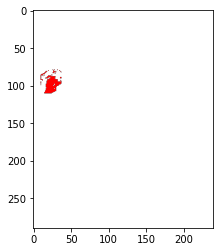

In [5]:
# import cv2
import numpy.ma as npm
x_size = int(PATH[-11:-8])-10
y_size = int(PATH[-7:-4])-10
lstm_gif_list = []
origin_gif_list = []
label_gif_list = []
concat_gif = []
output_acc = []
output = np.zeros((x_size, y_size, oupput_lstm.shape[1]))
for j in range(21):
    index_day = j

    lstm_conf = oupput_lstm[:, index_day, 0].reshape((x_size, y_size))
    origin_pic = predict_dataset[:, index_day, 12].reshape((x_size, y_size))
    ret,lstm_conf = cv2.threshold(lstm_conf,0,100,cv2.THRESH_TOZERO)
    ret,lstm_conf = cv2.threshold(lstm_conf,lstm_conf.mean(),100,cv2.THRESH_TOZERO)
    # print(np.median(lstm_conf))
    mask = origin_pic==0
    # print(mask)
    output[:,:,j] = lstm_conf
    o_min = lstm_conf.min()
    o_max = lstm_conf.max()
    print("{:02d}:00".format(j)+"to"+"{:02d}:59".format(j))
    image = npm.array(lstm_conf, mask=mask)
    # plt.imshow(lstm_conf)
    # plt.show()
    plt.imshow(origin_pic)
    plt.show()
    output_acc.append(lstm_conf)
 
    lstm_conf_png = np.zeros((lstm_conf.shape[0],lstm_conf.shape[1],4))
    lstm_conf_png[:,:,0] = ((lstm_conf - o_min) * (1/(o_max - o_min) * 255)).astype('uint8')
    lstm_conf_png[:,:,3] = ((lstm_conf - o_min) * (1/(o_max - o_min) * 255)).astype('uint8')
    plt.imshow(lstm_conf_png)
    plt.show()
    origin_pic = ((origin_pic - predict_dataset.min()) * (1/(predict_dataset.max() - predict_dataset.min()) * 255)).astype('uint8')
    # imsave('../img/lstm_conf' + str(j) + '.png', lstm_conf_png.astype(np.uint8))
eval_img = np.stack(output_acc, axis=2).sum(axis=2)

# np.save('output_Doctor_creek_fire_acc246*230.npy', eval_img)
    